# Wrangling and Analyzing Data
# 1. Introduction
Data preparation is always the hardest part of a data analyst's work flow, in this project, we will use the data wrangling skills to pull real-world data from Twitter, clean it, and do some analysis. We will get the original Twitter data from Twitter user @dog_rates, along with a image prediction dataset, to build our analysis.

WeRateDogs is a popular Twitter hash tag, as the name tells, people rate dogs with a denominator of 10 and the numerator is usually higher than 10 to show how lovely the dog is.

# 2. Gathering Data
1-Twitter archive file: download this file manually by clicking the following link: twitter_archive_enhanced.csv

2-The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

3-Twitter API & JSON: Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import HTML, display
from functools import reduce
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Read the twitter_archive csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
# Download the tsv file using the Requests library and the given URL
url =' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions.tsv', 'wb') as file:
        file.write(response.content)
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
# Setting up the Twitter API with authentication pieces
consumer_key = ' '
consumer_secret =' '
key =' '
secret =' '

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(key, secret)
api = tweepy.API(auth)

In [22]:
df_list = []
error_list = []

start = time.time()

# Will add each available tweet json to df_list
for tweet_id in df_twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # tweet's favorites
        retweets = tweet['retweet_count'] 
        user_followers = tweet['user']['followers_count'] 
        user_favourites = tweet['user']['favourites_count'] # user's favorites
        date_time = tweet['created_at'] # The date and time of the creation
             
        df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets),
                        'user_followers': int(user_followers), 'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})

        
    except Exception as e:
        print(str(tweet_id)+ " __ " + str(e)) 
        error_list.append(tweet_id)
        

end = time.time()
print(end - start)

888202515573088257 __ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 __ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 __ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 __ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 __ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 __ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 __ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 __ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 __ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 __ [{'code': 144, 'message': 'No status found with that ID.'}]
844223788422217728 __ Failed to send request: ('Connection aborted.', ConnectionResetError(54, 'Co

Rate limit reached. Sleeping for: 113


754011816964026368 __ [{'code': 144, 'message': 'No status found with that ID.'}]
680055455951884288 __ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 422


2107.7282769680023


In [54]:
print("The lengh of success the result", len(df_list))
print("The lengh of error the result", len(error_list))

The lengh of success the result 2330
The lengh of error the result 26


In [55]:
df_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets', 'user_followers',
                                               'user_favourites', 'date_time'])

In [57]:
print("The lengh of success the result", len(df_list))

The lengh of success the result 2330


In [189]:
df_tweets.to_csv('df_tweets.csv',index=False)

In [5]:
df_tweets = pd.read_csv('df_tweets.csv')
df_tweets.head()

,Unnamed: 0,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,0,892420643555336193,35385,7470,8898582,145976,2017-08-01 16:23:56+00:00
1,1,892177421306343426,30622,5547,8898582,145976,2017-08-01 00:17:27+00:00
2,2,891815181378084864,23040,3671,8898582,145976,2017-07-31 00:18:03+00:00
3,3,891689557279858688,38638,7637,8899220,145977,2017-07-30 15:58:51+00:00
4,4,891327558926688256,36955,8246,8898582,145976,2017-07-29 16:00:24+00:00


# Assessing Data
In this section the data sources are going to be assessed one by one. 
The first part of each data source outlines the process of assessing and shows my approach.
The second part states observations and issues I have found be fixed. 

In [6]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
df_twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [8]:
sum(df_twitter_archive.duplicated())

0

In [9]:
df_twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [10]:
df_twitter_archive.duplicated(subset=['tweet_id']).value_counts()

False    2356
dtype: int64

In [11]:
print(df_twitter_archive['doggo'].unique())
print(df_twitter_archive['floofer'].unique())
print(df_twitter_archive['pupper'].unique())
print(df_twitter_archive['puppo'].unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


In [12]:
df_twitter_archive.groupby(["doggo","floofer","pupper","puppo"])["tweet_id"].count().to_frame().reset_index().sort_values(by='tweet_id', ascending=False)

,doggo,floofer,pupper,puppo,tweet_id
0,None,None,None,None,1976
2,None,None,pupper,None,245
4,doggo,None,None,None,83
1,None,None,None,puppo,29
6,doggo,None,pupper,None,12
3,None,floofer,None,None,9
5,doggo,None,None,puppo,1
7,doggo,floofer,None,None,1


In [13]:
df_twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [14]:
df_twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [15]:
df_twitter_archive.groupby(["rating_numerator","rating_denominator"])["tweet_id"].count().to_frame().reset_index().sort_values(by='rating_numerator', ascending=False)

,rating_numerator,rating_denominator,tweet_id
44,1776,10,1
43,960,0,1
42,666,10,1
41,420,10,2
40,204,170,1
39,182,10,1
38,165,150,1
37,144,120,1
36,143,130,1
35,121,110,1


In [16]:
df_twitter_archive.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [17]:
df_twitter_archive.name


0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object

In [18]:
df_twitter_archive.name.value_counts()


None              745
a                  55
Charlie            12
Oliver             11
Cooper             11
                 ... 
Michelangelope      1
Karma               1
Rose                1
Saydee              1
Tito                1
Name: name, Length: 957, dtype: int64

###### There are some values in this column that looks not like a real name: a, an, the, very, and so on. They are all in lower case, so we may check the abnormality by this feature.



In [19]:
df_twitter_archive.loc[(df_twitter_archive.name.str.islower())].name.value_counts()


a               55
the              8
an               7
very             5
one              4
just             4
quite            4
mad              2
actually         2
getting          2
not              2
by               1
space            1
my               1
incredibly       1
infuriating      1
such             1
light            1
old              1
his              1
this             1
all              1
unacceptable     1
life             1
officially       1
Name: name, dtype: int64

In [20]:
df_twitter_archive.loc[(df_twitter_archive.name.str.islower())].name.value_counts().unique()


array([55,  8,  7,  5,  4,  2,  1])

###### The list above proves the hypothesis: lower case strings are not real names of dog.

##### name: this column has some missing values and some of the names are not real dog names but articles or adjectives.

In [21]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [23]:
sum(df_image_predictions.duplicated())

0

In [24]:
sum(df_image_predictions.jpg_url.duplicated())

66

In [25]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2330 non-null   int64 
 1   tweet_id         2330 non-null   int64 
 2   favorites        2330 non-null   int64 
 3   retweets         2330 non-null   int64 
 4   user_followers   2330 non-null   int64 
 5   user_favourites  2330 non-null   int64 
 6   date_time        2330 non-null   object
dtypes: int64(6), object(1)
memory usage: 127.5+ KB


In [26]:
sum(df_tweets.duplicated())

0

In [27]:
df_tweets.isnull().sum()

Unnamed: 0         0
tweet_id           0
favorites          0
retweets           0
user_followers     0
user_favourites    0
date_time          0
dtype: int64

# Quality Issues:
It mainly include issues like completeness, validity, accuracyand consistency

### df_twitter_archive:
    
1-remove tweets that has been replay as its not original.

2-remove tweets that has been rtweet as its not original.

3-When we back to twetter accaount"@dog_rates", there are ratings that are incorrect. I ordered the ratings from low to high and looked at the extremes only for incorrect ratings therefore there are likely more than I missed and will be difficult to find them all programmatically. Examples where things may have gone wrong is the use of decimals, or when two instances of numbers separated by a slash are present in 1 text and I assume the first was chosen. Also, there are ratings with decimals such as 13.5/10, 9.5/10 have been incorrectly extracted as 5/10 (in addition to other numbers with decimals such as 11.26 and 11.27). There are instances of 1/2 and 50/50 which are not ratings such signifying "half" which have been considered as ratings. Finally, use of 4/20 and 24/7 has been confused as ratings.
For future analysis it could be confusing to interpret unstandardized ratings. It is their gimmick to give dogs a rating of 100% but not all are above 100% so it could be interesting to see what % are below or above 100% and how this changed overtime by calculating a single value for rating.
There are many columns in this dataframe making it hard to read, and some will not be needed for analysis.

4-Correct numerator bigger than 14. 

5-Correct denominators not equal 10.

6- Combine rating_numerator and rating_denominator columns into one column.

7-replace the url from value of source .

8-The name column has many invalid values like , a, an, the.

### df_image_predictions:
1- drop duplicate jpg_url.

2-p1,p2 and p3 have inconsisitent capital words.

3-p1, p2, and p3 contain underscores instead of spaces in the labels

    
    
# Tidiness:   
Tidy data is a standard way of mapping the meaning of a dataset to its structure.
A dataset is messy or tidy depending on how rows, columns and tables are matched up with observations, variables and types.
In tidy data:

1-Merge three data frames.

2-There are multiple dog stages columns present e.g. doggo, pupper, etc. They should be merged into 1 column.

### Define
##### Merge the df_tweet and df_image_predictions tables to the df_twitter_archive table, both joining on tweet_id.

### Code

In [28]:
#Merge the df_twitter_archive, df_image_predictions, and df_tweets on 'tweet_id'
dfs = [df_twitter_archive, df_image_predictions, df_tweets]
twitter = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), dfs)
twitter.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_dog,p3,p3_conf,p3_dog,Unnamed: 0,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,banana,0.076110,False,0,35385,7470,8898582,145976,2017-08-01 16:23:56+00:00
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,papillon,0.068957,True,1,30622,5547,8898582,145976,2017-08-01 00:17:27+00:00
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,kelpie,0.031379,True,2,23040,3671,8898582,145976,2017-07-31 00:18:03+00:00
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,True,spatula,0.040836,False,3,38638,7637,8899220,145977,2017-07-30 15:58:51+00:00
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,German_short-haired_pointer,0.175219,True,4,36955,8246,8898582,145976,2017-07-29 16:00:24+00:00


In [29]:
twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_dog,p3,p3_conf,p3_dog,Unnamed: 0,favorites,retweets,user_followers,user_favourites,date_time
1725,672139350159835138,NaN,NaN,2015-12-02 19:44:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pup has a heart on its ass and that is do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672139350...,...,False,chimpanzee,0.115541,False,1992,1638,647,8898576,145976,2015-12-02 19:44:43+00:00
899,733828123016450049,NaN,NaN,2016-05-21 01:13:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Terry. The harder you hug him the fart...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/733828123...,...,True,Saint_Bernard,0.114640,True,1084,3479,752,8898569,145976,2016-05-21 01:13:53+00:00
1328,686618349602762752,NaN,NaN,2016-01-11 18:39:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Olivia. She just saw an adult wearing ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686618349...,...,True,Gordon_setter,0.093582,True,1565,3603,1318,8898574,145976,2016-01-11 18:39:05+00:00
349,818627210458333184,NaN,NaN,2017-01-10 01:15:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Wafer. He represents every fiber of my be...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818627210...,...,True,grocery_store,0.079799,False,434,22237,7458,8898565,145976,2017-01-10 01:15:10+00:00
1242,692828166163931137,NaN,NaN,2016-01-28 21:54:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper just descended from heaven. 12/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692828166...,...,False,white_wolf,0.003278,False,1467,2796,862,8898574,145976,2016-01-28 21:54:41+00:00


In [30]:
twitter['Unnamed: 0'].unique()

array([   0,    1,    2, ..., 2327, 2328, 2329])

###### After we creat the mearge for the three data frames appear index column(Unnamed: 0), we don't need it .

In [31]:
twitter.drop('Unnamed: 0',
  axis='columns', inplace=True)

### Test

In [32]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2057
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2058 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2058 non-null   object 
 4   source                      2058 non-null   object 
 5   text                        2058 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2058 non-null   object 
 10  rating_numerator            2058 non-null   int64  
 11  rating_denominator          2058 non-null   int64  
 12  name                        2058 non-null   object 
 13  doggo                       2058 

In [33]:
sum(twitter.duplicated())

0

In [34]:
twitter.nunique()

tweet_id                      2058
in_reply_to_status_id           22
in_reply_to_user_id              1
timestamp                     2058
source                           3
text                          2058
retweeted_status_id             72
retweeted_status_user_id        13
retweeted_status_timestamp      72
expanded_urls                 2058
rating_numerator                35
rating_denominator              15
name                           933
doggo                            2
floofer                          2
pupper                           2
puppo                            2
jpg_url                       1999
img_num                          4
p1                             378
p1_conf                       1996
p1_dog                           2
p2                             403
p2_conf                       1994
p2_dog                           2
p3                             407
p3_conf                       1996
p3_dog                           2
favorites           

In [35]:
twitter.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2035
in_reply_to_user_id           2035
timestamp                        0
source                           0
text                             0
retweeted_status_id           1986
retweeted_status_user_id      1986
retweeted_status_timestamp    1986
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
jpg_url                          0
img_num                          0
p1                               0
p1_conf                          0
p1_dog                           0
p2                               0
p2_conf                          0
p2_dog                           0
p3                               0
p3_conf                          0
p3_dog                           0
favorites           

### There are multiple dog stages columns present e.g. doggo, pupper, etc. They should be merged into 1 column



### Define
#### Create a new column named dog_stage. Extract doggo, floofer, pupper and puppo from the text column using pandas' str.extact method and place them into the dog_stage column. Fill the null values with None.

### code

In [36]:
twitter['dog_stage'] = twitter['text'].str.extract('(doggo|floof|pupper|puppo)',expand=True)
twitter = twitter.drop(['doggo','floofer','pupper','puppo'], axis=1)
twitter['dog_stage'].fillna('None', inplace=True)

### Test

In [37]:
twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,banana,0.07611,False,35385,7470,8898582,145976,2017-08-01 16:23:56+00:00,None


In [38]:
twitter.dog_stage.value_counts()

None      1705
pupper     230
doggo       73
puppo       28
floof       22
Name: dog_stage, dtype: int64

### remove tweets that has been replay as its not original.

### remove tweets that has been rtweet as its not original.



### Define
#### Drop the the columns related to the retweets and the replies: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id.

### Code

In [39]:
#step 1 : remove rows of reply and retweet tweets
twitter=twitter[twitter['in_reply_to_user_id'].isnull()]
twitter=twitter[twitter['in_reply_to_status_id'].isnull()]
twitter=twitter[twitter['retweeted_status_id'].isnull()]
twitter=twitter[twitter['retweeted_status_user_id'].isnull()]
twitter=twitter[twitter['retweeted_status_timestamp'].isnull()]

In [40]:
#step 2: drop 'retweeted_status_id', 'retweeted_status_user_id' and 
# 'retweeted_status_timestamp' columns
twitter = twitter.drop(['retweeted_status_id','retweeted_status_user_id',
                        'retweeted_status_timestamp'], axis=1)
#Remove in_reply_to_status_id,in_reply_to_user_id
twitter = twitter.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)

### Test

In [41]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2057
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1963 non-null   int64  
 1   timestamp           1963 non-null   object 
 2   source              1963 non-null   object 
 3   text                1963 non-null   object 
 4   expanded_urls       1963 non-null   object 
 5   rating_numerator    1963 non-null   int64  
 6   rating_denominator  1963 non-null   int64  
 7   name                1963 non-null   object 
 8   jpg_url             1963 non-null   object 
 9   img_num             1963 non-null   int64  
 10  p1                  1963 non-null   object 
 11  p1_conf             1963 non-null   float64
 12  p1_dog              1963 non-null   bool   
 13  p2                  1963 non-null   object 
 14  p2_conf             1963 non-null   float64
 15  p2_dog              1963 non-null   bool   
 16  p3    

###  p1,p2 and p3 have inconsisitent capital words

### Define
#### Replace the character '_' with space by using str.extract method and capitalize the first letters.

### Code

In [42]:
#to make all string lower case I will use lower() function on p1 ,p2 and p3 

twitter['p1']=twitter['p1'].str.lower()
twitter['p2']=twitter['p2'].str.lower()
twitter['p3']=twitter['p3'].str.lower()

### Test


In [43]:
twitter[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper_towel,labrador_retriever,spatula
4,basset,english_springer,german_short-haired_pointer


### Define
#### drop duplicate jpg_url.

### Code

In [44]:
# dropping duplicates jpg_url
twitter = twitter.drop_duplicates(subset=['jpg_url'], keep='last')

### Test

In [45]:
sum(twitter['jpg_url'].duplicated())

0

### Define

#### p1,p2 and p3 have unnessary underscore instead of space

### Code

In [46]:
# simply using string.replace function to repalce _ 
twitter['p1'] = twitter['p1'].str.replace('_', ' ')
twitter['p2'] = twitter['p2'].str.replace('_', ' ')
twitter['p3'] = twitter['p3'].str.replace('_', ' ')

### Test

In [47]:
twitter[twitter['p1']=='_'].value_counts()

Series([], dtype: int64)

In [48]:
twitter[twitter['p2']=='_'].value_counts()

Series([], dtype: int64)

In [49]:
twitter[twitter['p3']=='_'].value_counts()

Series([], dtype: int64)

In [50]:
twitter.groupby(['rating_numerator', 'rating_denominator']).size().reset_index(name='count')

,rating_numerator,rating_denominator,count
0,0,10,1
1,1,2,1
2,1,10,4
3,2,10,9
4,3,10,19
5,4,10,15
6,4,20,1
7,5,10,33
8,6,10,32
9,7,10,51


### Define

##### Issue: Some ratings with decimals such as 13.5/10, 9.5/10 have been incorrectly exported as 5/10 (in addition to other numbers with decimals such as 11.26 and 11.27).

##### Solution: Find all instances of ratings that contained decimals and replace the numerator values with the correct values.

### Code

In [51]:
twitter['rating_numerator'][twitter.rating_numerator == 50] = 11
twitter['rating_numerator'][twitter.rating_numerator == 27] = 11.27
twitter['rating_numerator'][twitter.rating_numerator == 75] = 9.75
twitter['rating_numerator'][twitter.rating_numerator == 26] = 11.26

### Test

In [52]:
twitter.groupby(['rating_numerator', 'rating_denominator']).size().reset_index(name='count')

,rating_numerator,rating_denominator,count
0,0.00,10,1
1,1.00,2,1
2,1.00,10,4
3,2.00,10,9
4,3.00,10,19
5,4.00,10,15
6,4.00,20,1
7,5.00,10,33
8,6.00,10,32
9,7.00,10,51


# Define

##### Issue: Some ratings with decimals such as 1776,24,420

##### Solution: remove from data frame

### Code

In [53]:
twitter=twitter[~twitter.rating_numerator.isin([1776,24,420])]
#twitter.rating_numerator = twitter.rating_numerator.astype('float') 
#twitter.rating_denominator = twitter.rating_denominator.astype('float')

### Test

In [54]:
twitter.groupby(['rating_numerator', 'rating_denominator']).size().reset_index(name='count')

,rating_numerator,rating_denominator,count
0,0.00,10,1
1,1.00,2,1
2,1.00,10,4
3,2.00,10,9
4,3.00,10,19
5,4.00,10,15
6,4.00,20,1
7,5.00,10,33
8,6.00,10,32
9,7.00,10,51


### Define

##### Issue: Some ratings with decimals as 99,80,45,60,44,84,204,121,144,88 ,  depande on number of dogs

##### Solution: numrate/denumurate

### Code

In [55]:
twitter['rating_numerator'][twitter.rating_numerator >14]=twitter['rating_numerator']/(twitter['rating_denominator'].div(10))

### Test

In [56]:
twitter.groupby(['rating_numerator', 'rating_denominator']).size().reset_index(name='count')

,rating_numerator,rating_denominator,count
0,0.00,10,1
1,1.00,2,1
2,1.00,10,4
3,2.00,10,9
4,3.00,10,19
5,4.00,10,15
6,4.00,20,1
7,5.00,10,33
8,6.00,10,32
9,7.00,10,51


### Define

#### Correct denominators not equal 10.

### Code

In [57]:
twitter.rating_denominator=10

### Test

In [58]:
twitter.groupby(['rating_numerator', 'rating_denominator']).size().reset_index(name='count')

,rating_numerator,rating_denominator,count
0,0.00,10,1
1,1.00,10,5
2,2.00,10,9
3,3.00,10,19
4,4.00,10,16
5,5.00,10,33
6,6.00,10,32
7,7.00,10,52
8,8.00,10,95
9,9.00,10,151


###  Combine rating_numerator and rating_denominator columns into one column

### Define

#### Create a rating column by dividing rating_numerator values by rating_denominator values for an easier data analysis.

### Code

In [59]:
twitter['rating'] = twitter.rating_numerator / twitter.rating_denominator

### Test

In [60]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960 entries, 0 to 2057
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1960 non-null   int64  
 1   timestamp           1960 non-null   object 
 2   source              1960 non-null   object 
 3   text                1960 non-null   object 
 4   expanded_urls       1960 non-null   object 
 5   rating_numerator    1960 non-null   float64
 6   rating_denominator  1960 non-null   int64  
 7   name                1960 non-null   object 
 8   jpg_url             1960 non-null   object 
 9   img_num             1960 non-null   int64  
 10  p1                  1960 non-null   object 
 11  p1_conf             1960 non-null   float64
 12  p1_dog              1960 non-null   bool   
 13  p2                  1960 non-null   object 
 14  p2_conf             1960 non-null   float64
 15  p2_dog              1960 non-null   bool   
 16  p3    

### Define

#### replace the url from value of source .

### code

In [61]:
twitter.loc[twitter['source'].str.contains('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'), 'source'] = 'Twitter for iPhone'
twitter.loc[twitter['source'].str.contains('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'), 'source'] = 'Twitter Web Client'
twitter.loc[twitter['source'].str.contains('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'), 'source'] = 'Vine - Make a Scene'
twitter.loc[twitter['source'].str.contains('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'), 'source'] = 'TweetDeck'

### Test

In [62]:
twitter.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'TweetDeck'],
      dtype=object)

### The name column has many invalid values like , a, an, the.



### Define
#### Names are probably extracted after the statements 'This is','Here is', 'hello to', 'Meet'. So that is why we have lots of words in the name column such that; a, an, the, etc. Notice that all of those are lowercase. Find the lowercase names in name cloumn and re-extract the names that come after the statements: 'name is' and 'named'. Replace the rest of the lowercase names with 'None'. Also, change the name 'O' with "O'Malley".

### Code

In [63]:
not_dog_names = twitter.loc[(twitter.name.str.islower())].name.value_counts().index.tolist()
not_dog_names.append('None')
not_dog_names

['a',
 'the',
 'an',
 'one',
 'very',
 'just',
 'quite',
 'getting',
 'unacceptable',
 'all',
 'this',
 'his',
 'actually',
 'officially',
 'my',
 'space',
 'by',
 'incredibly',
 'infuriating',
 'such',
 'light',
 'not',
 'None']

In [64]:
for name in not_dog_names:
    twitter.loc[twitter.name == name, 'name'] = None

### Test

In [65]:
twitter.name.value_counts()

Oliver       10
Charlie      10
Cooper       10
Penny         9
Lucy          9
             ..
Ruffles       1
Kathmandu     1
Antony        1
Kendall       1
Edd           1
Name: name, Length: 909, dtype: int64

## Storing Dataframe


In [66]:
# Save twitter dataframe to a CSV file
twitter.to_csv('twitter_archive_master.csv')

## Analyzing & Visualizing Data

In [67]:
twitter = pd.read_csv('twitter_archive_master.csv')
twitter.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,...,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time,dog_stage,rating
0,0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,banana,0.076110,False,35385,7470,8898582,145976,2017-08-01 16:23:56+00:00,None,1.3
1,1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,papillon,0.068957,True,30622,5547,8898582,145976,2017-08-01 00:17:27+00:00,None,1.3
2,2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,kelpie,0.031379,True,23040,3671,8898582,145976,2017-07-31 00:18:03+00:00,None,1.2
3,3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,spatula,0.040836,False,38638,7637,8899220,145977,2017-07-30 15:58:51+00:00,None,1.3
4,4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,german short-haired pointer,0.175219,True,36955,8246,8898582,145976,2017-07-29 16:00:24+00:00,None,1.2


In [68]:
twitter.head(1)

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,...,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time,dog_stage,rating
0,0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,banana,0.07611,False,35385,7470,8898582,145976,2017-08-01 16:23:56+00:00,None,1.3


### Which kind of source are people using the most?

In [69]:
twitter.source.value_counts()

Twitter for iPhone    1923
Twitter Web Client      28
TweetDeck                9
Name: source, dtype: int64

Text(0.5, 0, 'source')

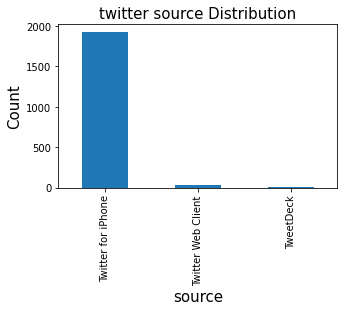

In [70]:
twitter.source.value_counts().plot(kind = 'bar', figsize=(5,3))
plt.title('twitter source Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('source', fontsize=15)

###### most people using Twitter for iPhone.

### What was the rating that most dogs got?

In [71]:
twitter['rating_numerator'].value_counts().sort_index()


0.00       1
1.00       5
2.00       9
3.00      19
4.00      16
5.00      33
6.00      32
7.00      52
8.00      95
9.00     151
9.75       1
10.00    417
11.00    398
11.26      1
11.27      1
12.00    447
13.00    249
14.00     33
Name: rating_numerator, dtype: int64

###### The rating that most dogs got was 12 over 10 .

### How many dogs were rated above 10?

In [72]:
print('{} dogs were rated above 10.'.format(round(twitter.rating_numerator[twitter.rating_numerator> 10]).count()))


1129 dogs were rated above 10.


### which breed of dog people love the most?

In [73]:
dog_favorites = twitter.groupby('p1')['favorites'].sum().sort_values(ascending=False).head(6)
dog_favorites

p1
golden retriever      1539306
labrador retriever     950379
pembroke               909140
chihuahua              626320
samoyed                469120
french bulldog         427760
Name: favorites, dtype: int64

In [74]:
dog_retweets = twitter.groupby('p1')['retweets'].sum().sort_values(ascending=False).head(6)
dog_retweets

p1
golden retriever      432151
labrador retriever    300458
pembroke              241376
chihuahua             193819
samoyed               149990
french bulldog        104131
Name: retweets, dtype: int64

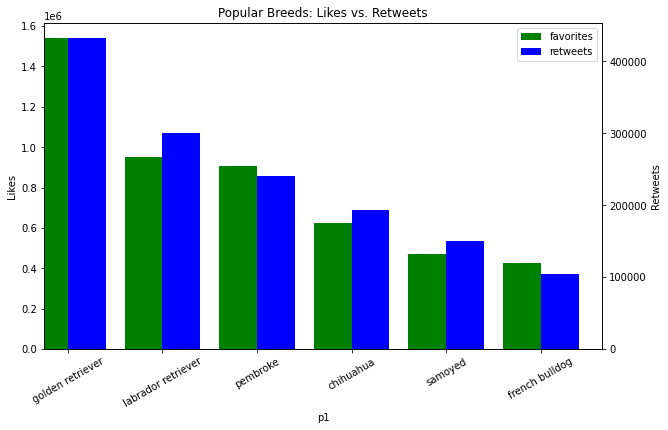

In [75]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


dog_favorites.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Popular Breeds: Likes vs. Retweets')
dog_retweets.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)

ax1.set_ylabel('Likes')
ax2.set_ylabel('Retweets')
ax1.set_xticklabels(dog_favorites.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

### What is the relation between Retweets and Likes?


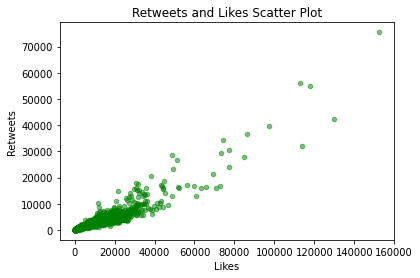

In [76]:
twitter.plot(kind='scatter',x='favorites',y='retweets', alpha = 0.5,color = 'green')
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Retweets and Likes Scatter Plot')

plt.savefig('Retweets_vs_Likes.png', bbox_inches='tight')

###### Retweets are positively correlated with Likes.

### what is the bar plot of dog stages?


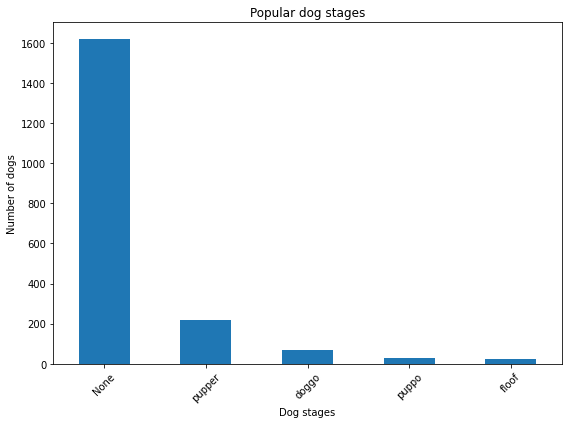

In [77]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(8,6))
twitter.dog_stage.value_counts().sort_values(ascending=False).plot.bar()
plt.title("Popular dog stages")
plt.xticks(rotation=45)
plt.xlabel("Dog stages")
plt.ylabel("Number of dogs");



###### There are 1566 dogs with unknown dog stage. It is a very high number and more time should be spent on cleaning dog_stage part. For now, I will exclude the category 'None' and continue to analyze it.

Text(0.5, 0, 'Dog Stage')

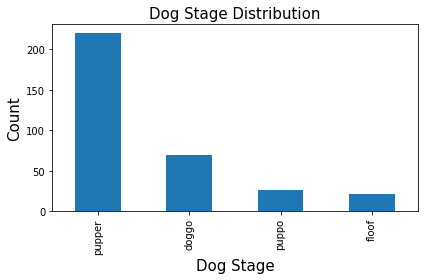

In [78]:
dog_stages=twitter.groupby('dog_stage').filter(lambda x: len(x) < 250)
dog_stages['dog_stage'].value_counts().plot(kind = 'bar')
plt.title('Dog Stage Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)

###### Most of the dogs are pupper.

### What are the 10 most frequent dog names?


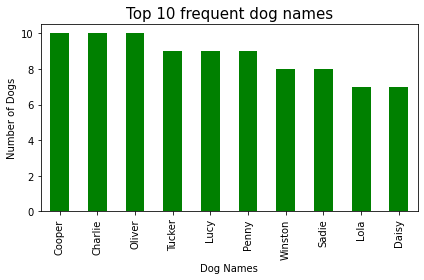

In [79]:
twitter['name'].value_counts()[0:10].sort_values(ascending=False).plot(kind = 'bar',color = 'green')
plt.ylabel('Number of Dogs')
plt.title('Top 10 frequent dog names', size=15)
plt.xlabel('Dog Names')
plt.savefig('most_frequent_names');

In [80]:
twitter['name'].value_counts()[0:10].sort_values(ascending=False)


Cooper     10
Charlie    10
Oliver     10
Tucker      9
Lucy        9
Penny       9
Winston     8
Sadie       8
Lola        7
Daisy       7
Name: name, dtype: int64